In [207]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import load_model, save_model
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix

In [0]:
usernames = ["JustinTrudeau","ElizabethMay","AndrewScheer","MaximeBernier","theJagmeetSingh"]
tweet_frames = []
retweet_frames = []
for username in usernames:
    tweet_frame = pd.read_csv("../data/{}_data.csv".format(username))
    retweet_frame = pd.read_csv("../data/{}_retweets.csv".format(username))
    tweet_frames.append(tweet_frame)
    retweet_frames.append(retweet_frame)
tweet_df = pd.concat(tweet_frames,sort=False)  
retweet_df = pd.concat(retweet_frames,sort=False)
print(tweet_df.shape,retweet_df.shape)
print(tweet_df.columns,retweet_df.columns)
print(len(retweet_df["original_author"].unique()))

In [0]:
merged_df = pd.merge(left=retweet_df,right=tweet_df, how='inner', left_on='original_tweet_id', right_on='id')
merged_df.head()

In [0]:
merged_df = merged_df.drop(['type_y','type_x', 'created_at_x', 'source_x',
       'favorite_count_x', 'retweet_count_x', 'id',
       'type_y', 'created_at_y', 'source_y', 'original_text', 'clean_text',
       'favorite_count_y', 'retweet_count_y', 'hashtags', 'mentions','to_date'],axis=1)
merged_df.columns = ['id', 'retweet_id','retweet_author','tweet_author','lda_cluster']
print(merged_df.columns,merged_df.shape)
merged_df.head()

In [0]:
merged_df = merged_df.groupby(['retweet_author', 'lda_cluster']).size().reset_index(name='count')
merged_df = merged_df.sort_values(by=['retweet_author','lda_cluster'])
# Remove all null topic tweets
merged_df = merged_df[merged_df["lda_cluster"] != -1]
# How many users tweeted more a topic more than once.
print(len(merged_df[merged_df["count"] > 1]))
merged_df.head()

In [0]:
# Pivot the data so that eac row is a user, and columns [1:] repreesnt the number of times a user tweeted that topic.
aggregated = merged_df.pivot(index='retweet_author', columns='lda_cluster', values='count')
aggregated.columns.name = None
aggregated = aggregated.reset_index()
aggregated = aggregated[:].fillna(0)
print(aggregated.columns)
aggregated.head()

In [0]:
def to_training_data(aRow):
    aRow = list(aRow)
    author = aRow[0]
    clusters = aRow[1:]
    columns = [str(i) for i in range(len(clusters))]
    columns.append("target")
    frames = []
    for index,val in enumerate(clusters):
        if val > 0:
            new_row = clusters.copy()
            # Obfuscate one of the vals
            new_row[index] -=1
            # This last index is the target
            new_row.append(index)
            frames.append(new_row)
    return pd.DataFrame(frames,columns=columns)

In [97]:
aggregate_df = list(aggregated.apply(lambda row : to_training_data(row),axis=1))
aggregate_df = pd.concat(aggregate_df)
print(aggregate_df.head())
aggregate_numpy = aggregate_df.to_numpy()

0    1    2    3    4    5    6  target
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0       1
0  0.0  0.0  0.0  0.0  1.0  1.0  0.0       3
1  0.0  0.0  0.0  1.0  0.0  1.0  0.0       4
2  0.0  0.0  0.0  1.0  1.0  0.0  0.0       5
0  0.0  0.0  0.0  0.0  1.0  0.0  0.0       3


In [193]:
msk = np.random.rand(len(aggregate_numpy)) < 0.8
training_data = aggregate_numpy[msk]
testing_data = aggregate_numpy[~msk]
print(training_data.shape,testing_data.shape)

(27042, 8) (6885, 8)


In [201]:
x_training, y_training = training_data[:,:-1],training_data[:,-1] 
x_testing, y_testing = testing_data[:,:-1],testing_data[:,-1] 
num_labels = len(np.unique(y_training))
#One hot encode
y_training_encoded = np.zeros((y_training.size, num_labels))
y_training_encoded[np.arange(y_training.size), y_training.astype(int)] = 1
y_testing_encoded = np.zeros((y_testing.size, num_labels))
y_testing_encoded[np.arange(y_testing.size), y_testing.astype(int)] = 1
print(x_training.shape,y_training_encoded.shape)

(27042, 7) (27042, 7)


In [221]:
# Since class 3 dominates the rest we are going to give different penalities for missclassifcation.
class_weights = compute_class_weight("balanced", np.unique(aggregate_numpy[:,-1]),aggregate_numpy[:,-1])
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

{0: 1.1509651592767243, 1: 0.7900104785190359, 2: 2.265878581446604, 3: 0.41609841051805335, 4: 0.6981726139029509, 5: 3.0949644225506296, 6: 3.7688291490779826}


In [247]:
print("--- Initializing Model ---")
opt = keras.optimizers.SGD(lr=0.01)
model = Sequential()
model.add(Dense(num_labels, activation="relu"))
model.add(Dense(15, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(7, activation="sigmoid"))
model.add(Dense(num_labels, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

--- Initializing Model ---


In [248]:
epochs = 15
batch_size = 64
callback = EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001,verbose=1)
model.fit(x_training,y_training_encoded, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[callback],class_weight=d_class_weights,verbose=1)
# history = model.fit(x_training,y_training_encoded, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[callback],verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 24337 samples, validate on 2705 samples
Epoch 1/15
24337/24337 [==============================] - 3s 110us/sample - loss: 0.6533 - accuracy: 0.6488 - val_loss: 0.5925 - val_accuracy: 0.8567
Epoch 2/15
24337/24337 [==============================] - 1s 45us/sample - loss: 0.5403 - accuracy: 0.8568 - val_loss: 0.5118 - val_accuracy: 0.8571
Epoch 3/15
24337/24337 [==============================] - 1s 42us/sample - loss: 0.4816 - accuracy: 0.8571 - val_loss: 0.4692 - val_accuracy: 0.8571
Epoch 4/15
24337/24337 [==============================] - 1s 48us/sample - loss: 0.4501 - accuracy: 0.8571 - val_loss: 0.4459 - val_accuracy: 0.8571
Epoch 5/15
24337/24337 [==============================] - 1s 42us/sample - loss: 0.4327 - accuracy: 0.8571 - val_loss: 0.4328 - val_accuracy: 0.8571
Epoch 6/15
24337/24337 [==============================] - 1s 40us/sample - loss: 0.4229 - accuracy: 0.8571 - val_loss: 0.4253 - val_accuracy: 0.8571
Epoch 

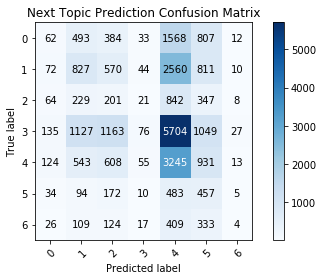

In [249]:
predictions = model.predict_classes(x_training)
classes = sorted(list(aggregate_df.columns)[:-1])
cm = confusion_matrix(y_training, predictions)
"""
This function prints and plots the confusion matrix.
Normalization can be applied by setting `normalize=True`.
"""
title = 'Next Topic Prediction Confusion Matrix'
    
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        # ... and label them with the respective list entries
        xticklabels=classes, yticklabels=classes,
        title=title,
        ylabel='True label',
        xlabel='Predicted label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
thresh = cm.max() / 2.
fmt = 'd'
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()

In [251]:
save_model(model,"dense_next_topic.h5")